4.  Entrenar una red neuronal que de la solucion de las siguientes ecuaciones diferenciales en el el intervalo [-5,5].  Graficar la solucion numerica junto con la solucion analitica.

(a) xy′+y=x^2cosx con y(0) = 0

In [7]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import RMSprop, Adam 

from matplotlib import pyplot as plt 
import numpy as np 
import math
import sympy as sp

In [26]:
class ODEsolver(Sequential): 
    def __init__(self, **kwargs): 
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss") #funcion de costo
        self.mse = tf.keras.losses.MeanSquaredError()
        
    @property 
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, data): #define el paso de entrenamiento
        batch_size = tf.shape(data)[0]
        min = tf.cast(tf.reduce_min(data),tf.float32)
        max = tf.cast(tf.reduce_max(data),tf.float32)
        x = tf.random.uniform((batch_size,1), minval=min, maxval=max)
        
        with tf.GradientTape() as tape: #calcula las derivadas 
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                y_pred = self(x, training = True) #evalua la derivada de x
            dy = tape2.gradient(y_pred, x) #derivada del modelo respecto a x 
            
            x_o = tf.zeros((batch_size, 1))
            y_o = self(x_o, training = True)
            
            eq = x* dy +y_pred - x*x*tf.cos(x) #Ecuación diferencial 
            ic = 0. #condición inicial 
            loss = keras.losses.mean_squared_error(0., eq) + keras.losses.mean_squared_error(y_o, ic) 
        # Calcular gradientes y aplicarlo
        grads =tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return  {"loss": self.loss_tracker.result()}

In [27]:
mse = tf.keras.losses.MeanSquaredError()
mse([[3],[5]], [[2],[1]])

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [28]:
keras.losses.mean_squared_error([[3],[5]], [[2],[1]])

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 1, 16])>

In [50]:
# Crear una instancia de la clase ODEsolver
model = ODEsolver()

# Definir las capas de la red neuronal
model.add(Dense(30, activation='tanh', input_shape=(1,)))
model.add(Dense(10, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation ="linear"))

# Imprimir un resumen del modelo
model.compile(optimizer='RMSprop', metrics=['loss']) 
model.summary()

Model: "od_esolver_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 30)                60        
                                                                 
 dense_42 (Dense)            (None, 10)                310       
                                                                 
 dense_43 (Dense)            (None, 20)                220       
                                                                 
 dense_44 (Dense)            (None, 10)                210       
                                                                 
 dense_45 (Dense)            (None, 1)                 11        
                                                                 
Total params: 811 (3.17 KB)
Trainable params: 811 (3.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
x = tf.linspace(-5.0, 5.0, 100)# Generar datos de entrada en el rango [-5, 5]
history = model.fit(x, epochs=1000, verbose=0)# Entrenar el modelo durante 500 épocas 

4/4 [==============================] - 1s 10ms/step


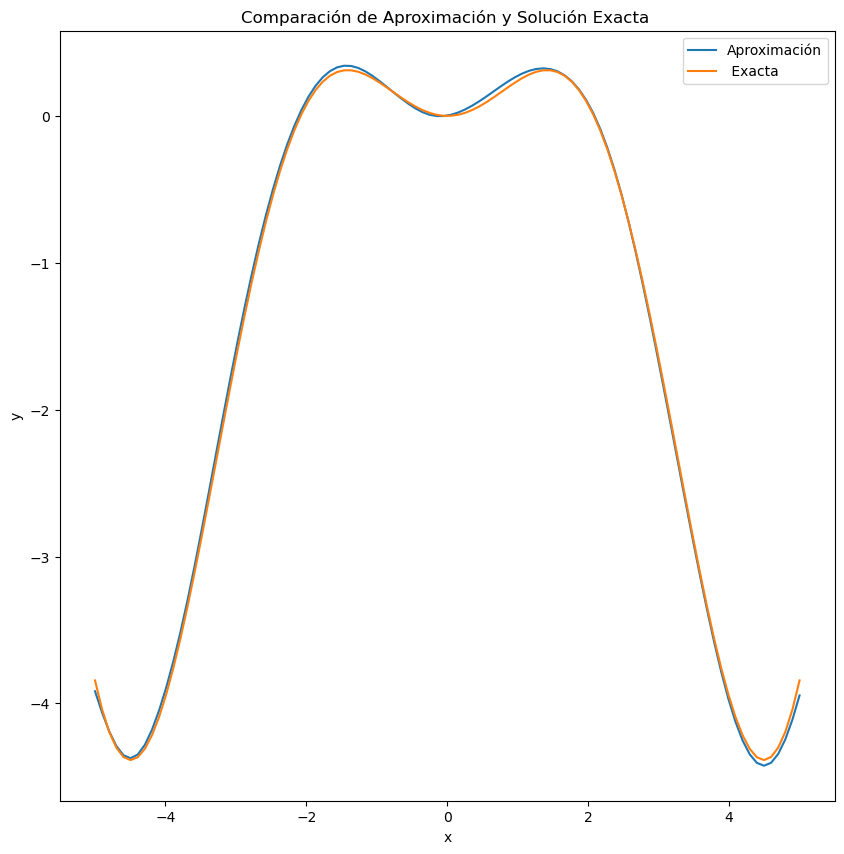

In [52]:
x_testv = tf.linspace(-5,5,100)# Generar datos de prueba en el rango [-5, 5] 
a=model.predict(x_testv)# Obtener las predicciones del modelo
exact_solution =x*np.sin(x) -2.*(-x*np.cos(x) + np.sin(x))/ x # solución exacta

# Graficar las predicciones y la solución exacta
plt.figure(figsize = (10,10))
plt.plot(x_testv, a, label="Aproximación")
plt.plot(x_testv, exact_solution, label=" Exacta")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparación de Aproximación y Solución Exacta ')
plt.show()